In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import os
from zipfile import ZipFile

2024-02-26 19:08:45.707008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 19:08:45.707091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 19:08:45.823930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path_to_models = '/kaggle/working/models'

os.mkdir(path_to_models)
os.mkdir(f"{path_to_models}/figure/")
os.mkdir(f"{path_to_models}/weights/")
output_zip_file = f"{path_to_models}/weights/"

FileExistsError: [Errno 17] File exists: '/kaggle/working/models'

In [5]:
def saving(models, epoch, names,path_to_models,output_zip_file):
    if not type(names) is list:
        names = [names]
    if not type(models) is list:
        models = [models]

    for i,m in enumerate(models):
        m.save(f'{path_to_models}/{names[i]}')

    zip_directory(path_to_models, output_zip_file,epoch)

def zip_directory(directory_path, zip_file_path,epoch):
    with ZipFile(f"{output_zip_file}/models_output_epoch_{epoch}.zip", 'w') as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, directory_path)
                zipf.write(f"{file_path}", arcname=arcname)



In [6]:
def unet_generator(latent_dim):
    model = Sequential()
  # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


In [7]:
def unet_discriminator():
    model = Sequential()
  # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
  # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [8]:
(train_images, _), (_, _) = cifar10.load_data()
train_images = ((train_images - 127.5) / 127.5).astype(np.float32)  # Normalize between -1 and 1

170498071/170498071 [==============================] - 3s 0us/step


In [10]:
def testing(path, epoch):
    num_images = 10
    noise = tf.random.normal((num_images, latent_dim))  # Correct noise dimension
    generated_images = generator(noise, training=False)  # Use generator model directly for inference
    plt.figure(figsize=(4, 2))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        image = tf.cast(generated_images[i] * 127.5 + 127.5, tf.uint8)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{path}generator_epoch_{epoch}.png")
    plt.show()


In [29]:
@tf.function
def train_step(real_images, noise, clip_value = 0.01):
    with tf.GradientTape() as disc_grad_tape, tf.GradientTape() as gen_grad_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        err_disc_real = loss_function(tf.ones([batch_size, 1]), real_output) / 2
        err_disc_fake = loss_function(tf.zeros([batch_size, 1]), fake_output) / 2
        err_disc = err_disc_real + err_disc_fake
        err_gen = loss_function(tf.ones([batch_size, 1]), fake_output)
    gradients_of_discriminator = disc_grad_tape.gradient(err_disc, discriminator.trainable_variables)
    gradients_of_generator = gen_grad_tape.gradient(err_gen, generator.trainable_variables)
    clipped_gradients_gen = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients_of_generator]
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(clipped_gradients_gen, generator.trainable_variables))
    return err_disc, err_gen

In [17]:
def train(start_epoch):
    image_size = len(train_images)
    steps = image_size // batch_size
    for epoch in range(50):
        loss_disc = 0
        loss_gen = 0
        if epoch % 5 == 0:
            testing(f"{path_to_models}/figure/", start_epoch + epoch)
        for i in trange(0, steps):
            rinx = np.random.choice(image_size, batch_size)
            real_images = train_images[rinx]
            noise = tf.random.normal((batch_size, latent_dim))
            err_disc, err_gen = train_step(real_images, noise)
            loss_disc += err_disc
            loss_gen  += err_gen
        print(f">Epoch: {epoch + start_epoch}, Discriminator Loss: {loss_disc/image_size}, Generator Loss: {loss_gen/image_size}")

In [14]:
# Initialize generator and discriminator
latent_dim = 100
generator = unet_generator(latent_dim)
discriminator = unet_discriminator()

Learning rate = 0.0002 Beta 1 = 0.5 for both optimizer

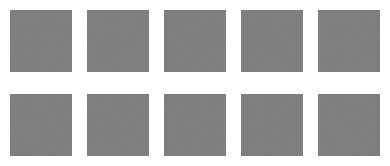

  0%|          | 0/195 [00:00<?, ?it/s]

I0000 00:00:1708974617.517388      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


>Epoch: 1, Discriminator Loss: 68.34959411621094, Generator Loss: 315.9007263183594


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 2, Discriminator Loss: 36.372840881347656, Generator Loss: 1279.380615234375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 3, Discriminator Loss: 51.281185150146484, Generator Loss: 478.7771301269531


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 4, Discriminator Loss: 94.58382415771484, Generator Loss: 226.04031372070312


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 5, Discriminator Loss: 98.47755432128906, Generator Loss: 269.3328857421875


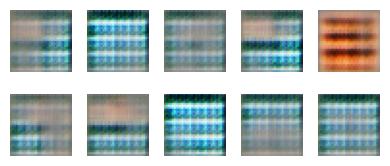

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 6, Discriminator Loss: 91.1794204711914, Generator Loss: 230.18222045898438


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 7, Discriminator Loss: 108.20883178710938, Generator Loss: 201.61878967285156


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 8, Discriminator Loss: 109.84040069580078, Generator Loss: 205.97840881347656


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 9, Discriminator Loss: 106.57083129882812, Generator Loss: 205.7820587158203


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 10, Discriminator Loss: 112.0528564453125, Generator Loss: 194.79014587402344


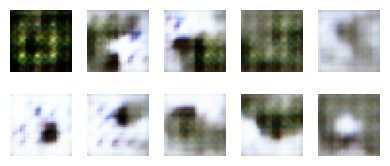

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 11, Discriminator Loss: 108.29644775390625, Generator Loss: 197.00628662109375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 12, Discriminator Loss: 120.06311798095703, Generator Loss: 182.2433319091797


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 13, Discriminator Loss: 113.91316986083984, Generator Loss: 186.3534698486328


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 14, Discriminator Loss: 112.52533721923828, Generator Loss: 193.48670959472656


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 15, Discriminator Loss: 114.02058410644531, Generator Loss: 190.0921630859375


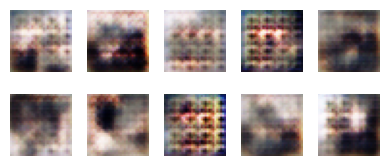

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 16, Discriminator Loss: 106.20316314697266, Generator Loss: 203.8408966064453


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 17, Discriminator Loss: 109.72647094726562, Generator Loss: 203.45046997070312


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 18, Discriminator Loss: 106.69856262207031, Generator Loss: 207.52609252929688


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 19, Discriminator Loss: 102.98633575439453, Generator Loss: 210.68255615234375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 20, Discriminator Loss: 96.58380889892578, Generator Loss: 234.11692810058594


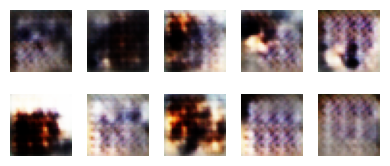

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 21, Discriminator Loss: 95.1609115600586, Generator Loss: 242.5050506591797


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 22, Discriminator Loss: 98.96235656738281, Generator Loss: 231.38975524902344


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 23, Discriminator Loss: 96.50553131103516, Generator Loss: 240.35049438476562


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 24, Discriminator Loss: 93.66748046875, Generator Loss: 255.8003387451172


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 25, Discriminator Loss: 91.00128173828125, Generator Loss: 265.58953857421875


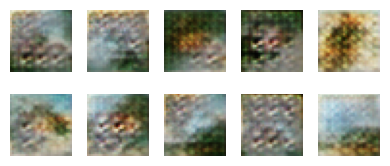

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 26, Discriminator Loss: 85.87541198730469, Generator Loss: 263.8031005859375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 27, Discriminator Loss: 89.88768768310547, Generator Loss: 269.8616943359375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 28, Discriminator Loss: 85.14269256591797, Generator Loss: 271.3251647949219


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 29, Discriminator Loss: 85.99427795410156, Generator Loss: 282.4905700683594


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 30, Discriminator Loss: 88.90213775634766, Generator Loss: 273.2855224609375


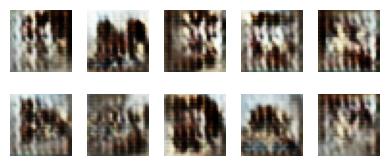

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 31, Discriminator Loss: 91.80862426757812, Generator Loss: 256.3364562988281


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 32, Discriminator Loss: 90.85546112060547, Generator Loss: 247.44918823242188


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 33, Discriminator Loss: 88.8448715209961, Generator Loss: 257.8606872558594


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 34, Discriminator Loss: 94.54788970947266, Generator Loss: 254.3712615966797


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 35, Discriminator Loss: 84.9959487915039, Generator Loss: 305.3369445800781


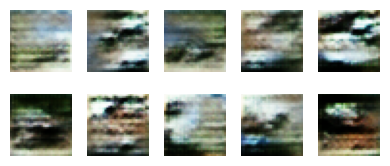

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 36, Discriminator Loss: 89.57041931152344, Generator Loss: 261.7691955566406


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 37, Discriminator Loss: 88.42898559570312, Generator Loss: 259.0663757324219


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 38, Discriminator Loss: 89.75459289550781, Generator Loss: 262.9833984375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 39, Discriminator Loss: 91.25672149658203, Generator Loss: 257.33349609375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 40, Discriminator Loss: 94.84687805175781, Generator Loss: 239.9876708984375


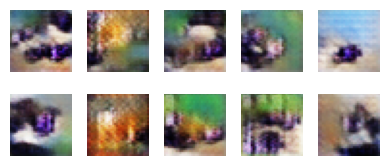

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 41, Discriminator Loss: 96.84993743896484, Generator Loss: 229.70333862304688


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 42, Discriminator Loss: 106.72063446044922, Generator Loss: 211.07371520996094


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 43, Discriminator Loss: 110.84089660644531, Generator Loss: 197.89950561523438


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 44, Discriminator Loss: 114.67322540283203, Generator Loss: 187.83731079101562


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 45, Discriminator Loss: 114.53782653808594, Generator Loss: 190.9531707763672


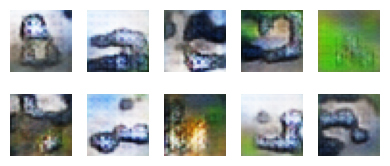

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 46, Discriminator Loss: 115.51971435546875, Generator Loss: 184.0281524658203


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 47, Discriminator Loss: 116.4944076538086, Generator Loss: 183.04635620117188


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 48, Discriminator Loss: 114.6858139038086, Generator Loss: 185.5494842529297


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 49, Discriminator Loss: 115.0253677368164, Generator Loss: 189.7585906982422


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 50, Discriminator Loss: 114.72550964355469, Generator Loss: 183.96153259277344


In [15]:
generator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)

# Other hyperparameters
batch_size = 256
loss_function = BinaryCrossentropy()

# Training loop
start_epoch = 1
train(start_epoch)

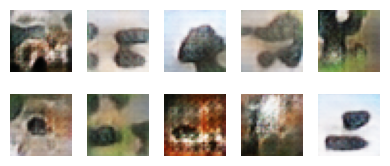

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 51, Discriminator Loss: 115.83926391601562, Generator Loss: 184.66253662109375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 52, Discriminator Loss: 115.22604370117188, Generator Loss: 185.2603759765625


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 53, Discriminator Loss: 114.2985610961914, Generator Loss: 186.47116088867188


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 54, Discriminator Loss: 115.58039093017578, Generator Loss: 184.6087646484375


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 55, Discriminator Loss: 113.59381103515625, Generator Loss: 187.3660125732422


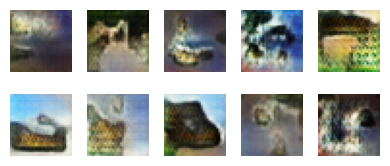

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 56, Discriminator Loss: 113.40037536621094, Generator Loss: 189.03012084960938


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 57, Discriminator Loss: 114.39176177978516, Generator Loss: 189.80392456054688


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 58, Discriminator Loss: 113.07894134521484, Generator Loss: 190.50059509277344


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 59, Discriminator Loss: 113.95369720458984, Generator Loss: 186.42013549804688


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 60, Discriminator Loss: 114.32593536376953, Generator Loss: 188.67808532714844


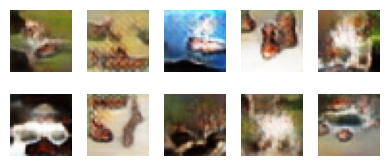

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 61, Discriminator Loss: 112.58051300048828, Generator Loss: 191.79727172851562


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 62, Discriminator Loss: 113.73696899414062, Generator Loss: 188.7947998046875


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 63, Discriminator Loss: 114.20001983642578, Generator Loss: 189.84393310546875


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 64, Discriminator Loss: 113.63666534423828, Generator Loss: 187.4630889892578


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 65, Discriminator Loss: 113.34388732910156, Generator Loss: 188.44091796875


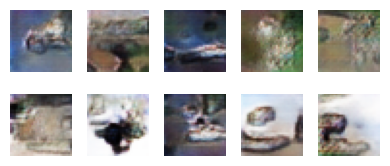

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 66, Discriminator Loss: 115.79672241210938, Generator Loss: 186.60641479492188


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 67, Discriminator Loss: 113.67200469970703, Generator Loss: 185.2052764892578


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 68, Discriminator Loss: 113.22417449951172, Generator Loss: 185.23475646972656


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 69, Discriminator Loss: 113.95415496826172, Generator Loss: 190.8184356689453


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 70, Discriminator Loss: 113.92886352539062, Generator Loss: 186.0756072998047


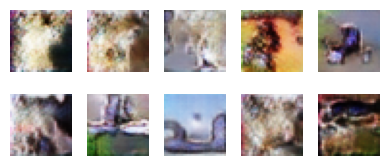

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 71, Discriminator Loss: 113.52571868896484, Generator Loss: 187.67880249023438


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 79, Discriminator Loss: 114.94227600097656, Generator Loss: 185.2465362548828


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 80, Discriminator Loss: 115.40328979492188, Generator Loss: 179.81202697753906


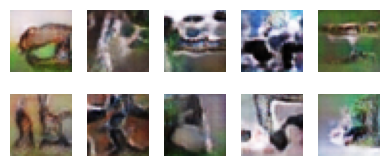

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 81, Discriminator Loss: 114.19664764404297, Generator Loss: 185.4248504638672


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 82, Discriminator Loss: 115.00740051269531, Generator Loss: 183.858642578125


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 83, Discriminator Loss: 114.41551971435547, Generator Loss: 185.3280029296875


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 84, Discriminator Loss: 115.24946594238281, Generator Loss: 188.22222900390625


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 85, Discriminator Loss: 114.38317108154297, Generator Loss: 183.94557189941406


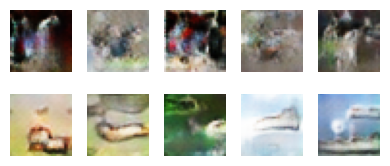

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 86, Discriminator Loss: 114.25946807861328, Generator Loss: 185.110595703125


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 87, Discriminator Loss: 114.7070541381836, Generator Loss: 181.63021850585938


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 88, Discriminator Loss: 114.34837341308594, Generator Loss: 184.67294311523438


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 89, Discriminator Loss: 114.49506378173828, Generator Loss: 184.20803833007812


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 90, Discriminator Loss: 114.6003646850586, Generator Loss: 183.48818969726562


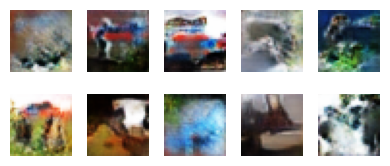

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 91, Discriminator Loss: 114.00540924072266, Generator Loss: 185.6388702392578


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 92, Discriminator Loss: 113.525634765625, Generator Loss: 185.93435668945312


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 93, Discriminator Loss: 114.27218627929688, Generator Loss: 185.42698669433594


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 94, Discriminator Loss: 113.68177795410156, Generator Loss: 191.26177978515625


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 95, Discriminator Loss: 112.93034362792969, Generator Loss: 185.97422790527344


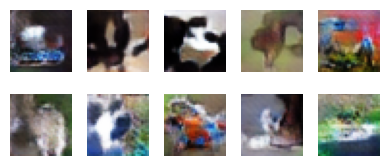

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 96, Discriminator Loss: 114.02293395996094, Generator Loss: 184.64622497558594


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 97, Discriminator Loss: 115.78598022460938, Generator Loss: 187.622314453125


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 98, Discriminator Loss: 113.95281219482422, Generator Loss: 187.43783569335938


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 99, Discriminator Loss: 113.81583404541016, Generator Loss: 184.04127502441406


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 100, Discriminator Loss: 113.75184631347656, Generator Loss: 186.77952575683594


In [16]:
generator_optimizer = Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0005, beta_1=0.5)

# Other hyperparameters
batch_size = 256
loss_function = BinaryCrossentropy()

# Training loop
start_epoch = 51
train(start_epoch)

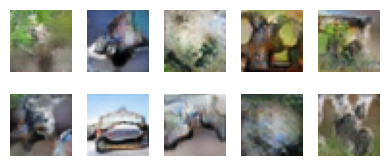

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 101, Discriminator Loss: 0.0022735595703125, Generator Loss: 0.003712817095220089


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 102, Discriminator Loss: 0.0022645823191851377, Generator Loss: 0.003828131826594472


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 103, Discriminator Loss: 0.0022772757802158594, Generator Loss: 0.003712823148816824


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 104, Discriminator Loss: 0.002260242821648717, Generator Loss: 0.0037352440413087606


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 105, Discriminator Loss: 0.002262337598949671, Generator Loss: 0.003774655517190695


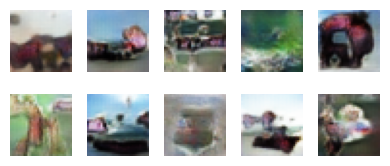

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 106, Discriminator Loss: 0.002269707852974534, Generator Loss: 0.003734012832865119


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 107, Discriminator Loss: 0.0022673613857477903, Generator Loss: 0.003752049757167697


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 108, Discriminator Loss: 0.00227758870460093, Generator Loss: 0.003759520361199975


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 109, Discriminator Loss: 0.0022760494612157345, Generator Loss: 0.003821492660790682


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 110, Discriminator Loss: 0.0022579331416636705, Generator Loss: 0.0037488644011318684


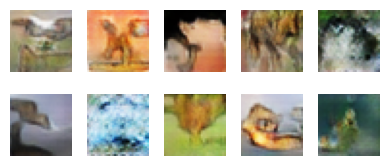

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 111, Discriminator Loss: 0.0022671122569590807, Generator Loss: 0.003779625054448843


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 112, Discriminator Loss: 0.002331711119040847, Generator Loss: 0.00376368616707623


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 113, Discriminator Loss: 0.0022735963575541973, Generator Loss: 0.0037282053381204605


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 114, Discriminator Loss: 0.002274444792419672, Generator Loss: 0.0037469896487891674


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 115, Discriminator Loss: 0.0022635948844254017, Generator Loss: 0.003757345024496317


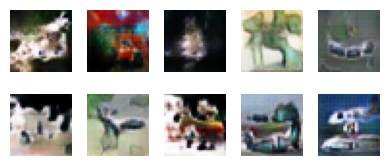

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 116, Discriminator Loss: 0.0022780399303883314, Generator Loss: 0.0037253699265420437


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 118, Discriminator Loss: 0.002287105191498995, Generator Loss: 0.003765512490645051


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 119, Discriminator Loss: 0.0022528478875756264, Generator Loss: 0.0038281066808849573


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 120, Discriminator Loss: 0.0022952724248170853, Generator Loss: 0.003783073043450713


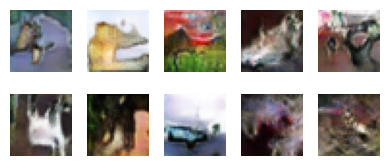

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 121, Discriminator Loss: 0.002273145131766796, Generator Loss: 0.0037270868197083473


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 122, Discriminator Loss: 0.0022794397082179785, Generator Loss: 0.0037240758538246155


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 123, Discriminator Loss: 0.002282841596752405, Generator Loss: 0.0037333471700549126


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 124, Discriminator Loss: 0.0022715795785188675, Generator Loss: 0.0037485992070287466


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 125, Discriminator Loss: 0.0023314314894378185, Generator Loss: 0.0037112075369805098


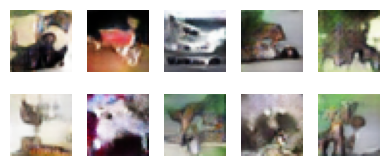

  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 126, Discriminator Loss: 0.002279918408021331, Generator Loss: 0.0036963678430765867


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 127, Discriminator Loss: 0.002272774698212743, Generator Loss: 0.003764846595004201


  0%|          | 0/195 [00:00<?, ?it/s]

>Epoch: 128, Discriminator Loss: 0.0022828232031315565, Generator Loss: 0.003768726484850049


  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
generator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)

# Other hyperparameters
batch_size = 256
loss_function = BinaryCrossentropy()

# Training loop
start_epoch = 101
train(start_epoch)

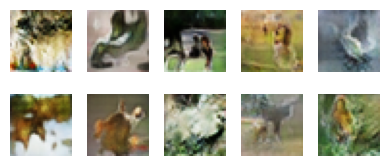

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 151, Discriminator Loss: 0.0010325406910851598, Generator Loss: 0.002196886111050844


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 152, Discriminator Loss: 0.0010461797937750816, Generator Loss: 0.002155463909730315


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 153, Discriminator Loss: 0.001069937483407557, Generator Loss: 0.0020914373453706503


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 154, Discriminator Loss: 0.0010988314170390368, Generator Loss: 0.00201390590518713


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 155, Discriminator Loss: 0.0011082401033490896, Generator Loss: 0.0019448891980573535


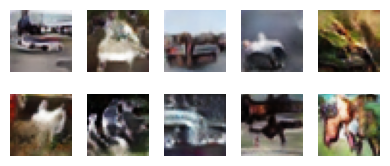

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 156, Discriminator Loss: 0.001113368198275566, Generator Loss: 0.0019005878129974008


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 157, Discriminator Loss: 0.0011099099647253752, Generator Loss: 0.0018624248914420605


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 158, Discriminator Loss: 0.0011123809963464737, Generator Loss: 0.0018307437421754003


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 159, Discriminator Loss: 0.0011088413884863257, Generator Loss: 0.0018146531656384468


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 160, Discriminator Loss: 0.001110237673856318, Generator Loss: 0.0018088128417730331


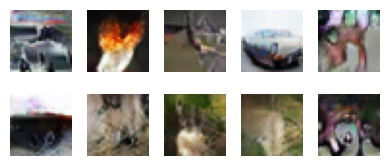

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 161, Discriminator Loss: 0.0011107891332358122, Generator Loss: 0.001803034101612866


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 162, Discriminator Loss: 0.0011145180324092507, Generator Loss: 0.001810631132684648


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 163, Discriminator Loss: 0.001118152285926044, Generator Loss: 0.0018070020014420152


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 164, Discriminator Loss: 0.001116603147238493, Generator Loss: 0.0018141032196581364


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 165, Discriminator Loss: 0.0011145753087475896, Generator Loss: 0.001820799894630909


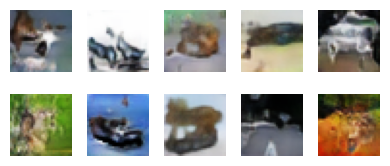

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 166, Discriminator Loss: 0.0011193277314305305, Generator Loss: 0.0018205741653218865


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 167, Discriminator Loss: 0.0011176497209817171, Generator Loss: 0.0018221221398562193


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 168, Discriminator Loss: 0.0011212906101718545, Generator Loss: 0.0018094634870067239


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 169, Discriminator Loss: 0.0011215743143111467, Generator Loss: 0.001807060674764216


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 170, Discriminator Loss: 0.0011205532355234027, Generator Loss: 0.001802937826141715


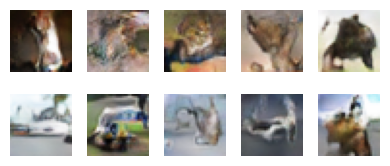

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 171, Discriminator Loss: 0.0011233133263885975, Generator Loss: 0.0017982935532927513


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 172, Discriminator Loss: 0.0011213173856958747, Generator Loss: 0.0017944329883903265


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 173, Discriminator Loss: 0.001122436486184597, Generator Loss: 0.0017937844386324286


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 174, Discriminator Loss: 0.0011212237877771258, Generator Loss: 0.0017876193160191178


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 175, Discriminator Loss: 0.0011242760811001062, Generator Loss: 0.0017932087648659945


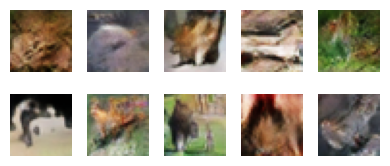

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 176, Discriminator Loss: 0.0011245118221268058, Generator Loss: 0.0017901466926559806


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 177, Discriminator Loss: 0.0011207726784050465, Generator Loss: 0.0017930525355041027


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 178, Discriminator Loss: 0.0011220964370295405, Generator Loss: 0.0017891270108520985


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 179, Discriminator Loss: 0.0011190386721864343, Generator Loss: 0.0017976354574784636


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 180, Discriminator Loss: 0.0011205188930034637, Generator Loss: 0.001796614844352007


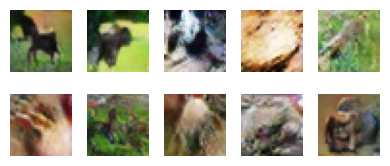

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 181, Discriminator Loss: 0.0011175787076354027, Generator Loss: 0.0018039959250018


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 182, Discriminator Loss: 0.0011181792942807078, Generator Loss: 0.001799277146346867


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 183, Discriminator Loss: 0.0011200009612366557, Generator Loss: 0.0017983728321269155


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 184, Discriminator Loss: 0.0011197151616215706, Generator Loss: 0.0017984452424570918


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 185, Discriminator Loss: 0.0011186366900801659, Generator Loss: 0.0018004095181822777


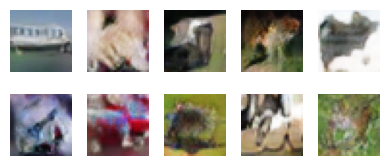

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 186, Discriminator Loss: 0.0011170579819008708, Generator Loss: 0.0018040980212390423


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 187, Discriminator Loss: 0.0011192032834514976, Generator Loss: 0.0017957298550754786


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 188, Discriminator Loss: 0.0011146912584081292, Generator Loss: 0.00180145725607872


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 189, Discriminator Loss: 0.0011173379607498646, Generator Loss: 0.001806190935894847


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 190, Discriminator Loss: 0.0011132827494293451, Generator Loss: 0.001806646934710443


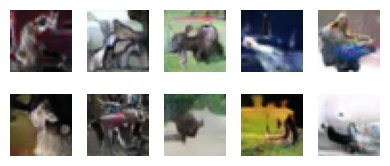

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 191, Discriminator Loss: 0.0011135854292660952, Generator Loss: 0.001805089064873755


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 192, Discriminator Loss: 0.001112668658606708, Generator Loss: 0.0018079139990732074


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 193, Discriminator Loss: 0.0011142779840156436, Generator Loss: 0.0018021737923845649


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 194, Discriminator Loss: 0.0011166010517627, Generator Loss: 0.0018023231532424688


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 195, Discriminator Loss: 0.0011197890853509307, Generator Loss: 0.00179591856431216


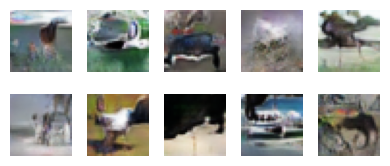

  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 196, Discriminator Loss: 0.0011187244672328234, Generator Loss: 0.0017980148550122976


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 197, Discriminator Loss: 0.00111952715087682, Generator Loss: 0.001797705888748169


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 198, Discriminator Loss: 0.0011251282412558794, Generator Loss: 0.0017949618631973863


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 199, Discriminator Loss: 0.0011192287784069777, Generator Loss: 0.001793453935533762


  0%|          | 0/97 [00:00<?, ?it/s]

>Epoch: 200, Discriminator Loss: 0.001120725297369063, Generator Loss: 0.0017996616661548615


In [24]:
generator_optimizer = Adam(learning_rate=0.000001, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.000001, beta_1=0.5)

# Other hyperparameters
batch_size = 512
loss_function = BinaryCrossentropy()

# Training loop
start_epoch = 151
train(start_epoch)

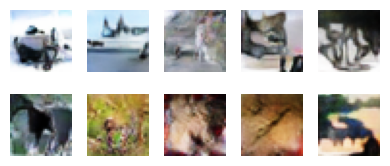

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 201, Discriminator Loss: 0.0005534724332392216, Generator Loss: 0.0008881987887434661


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 202, Discriminator Loss: 0.000554473721422255, Generator Loss: 0.0008873477927409112


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 203, Discriminator Loss: 0.0005514961085282266, Generator Loss: 0.0008877726504579186


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 204, Discriminator Loss: 0.0005540158599615097, Generator Loss: 0.0008871749159879982


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 205, Discriminator Loss: 0.000553309393581003, Generator Loss: 0.0008894967613741755


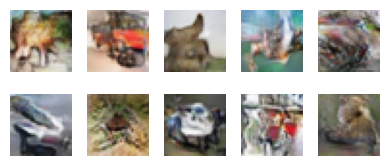

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 206, Discriminator Loss: 0.0005520699196495116, Generator Loss: 0.0008885283023118973


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 207, Discriminator Loss: 0.0005534224910661578, Generator Loss: 0.0008867657743394375


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 208, Discriminator Loss: 0.0005538417608477175, Generator Loss: 0.0008883774280548096


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 209, Discriminator Loss: 0.0005545950843952596, Generator Loss: 0.0008872650214470923


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 210, Discriminator Loss: 0.0005522929131984711, Generator Loss: 0.0008893319172784686


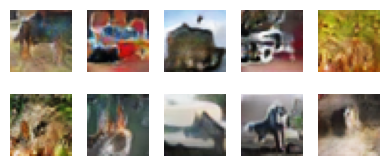

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 211, Discriminator Loss: 0.0005532953073270619, Generator Loss: 0.0008888961747288704


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 212, Discriminator Loss: 0.0005530135240405798, Generator Loss: 0.0008884812705218792


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 213, Discriminator Loss: 0.0005537334945984185, Generator Loss: 0.0008888313313946128


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 214, Discriminator Loss: 0.0005538907134905457, Generator Loss: 0.0008885091519914567


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 215, Discriminator Loss: 0.0005539815756492317, Generator Loss: 0.0008878099615685642


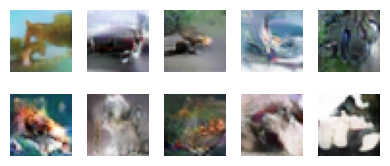

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 216, Discriminator Loss: 0.0005551611538976431, Generator Loss: 0.0008872349280864


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 217, Discriminator Loss: 0.0005525789456441998, Generator Loss: 0.0008885238785296679


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 218, Discriminator Loss: 0.0005529873305931687, Generator Loss: 0.0008882595575414598


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 219, Discriminator Loss: 0.0005520954728126526, Generator Loss: 0.0008910864125937223


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 220, Discriminator Loss: 0.000553622841835022, Generator Loss: 0.0008877821383066475


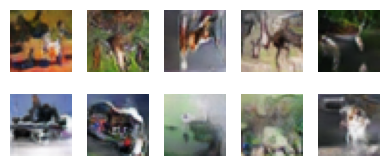

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 221, Discriminator Loss: 0.0005534198717214167, Generator Loss: 0.0008876876090653241


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 222, Discriminator Loss: 0.0005531212664209306, Generator Loss: 0.0008893674239516258


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 223, Discriminator Loss: 0.0005535517702810466, Generator Loss: 0.0008894010679796338


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 224, Discriminator Loss: 0.0005536378594115376, Generator Loss: 0.0008890041499398649


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 225, Discriminator Loss: 0.0005533773801289499, Generator Loss: 0.0008890843018889427


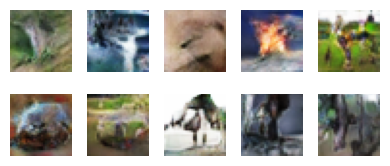

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 226, Discriminator Loss: 0.0005514359218068421, Generator Loss: 0.0008882172987796366


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 227, Discriminator Loss: 0.000554379599634558, Generator Loss: 0.0008854128536768258


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 228, Discriminator Loss: 0.0005523496656678617, Generator Loss: 0.0008894592174328864


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 229, Discriminator Loss: 0.0005524348234757781, Generator Loss: 0.0008882828406058252


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 230, Discriminator Loss: 0.0005514923832379282, Generator Loss: 0.0008910187752917409


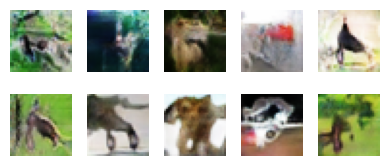

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 231, Discriminator Loss: 0.0005530831404030323, Generator Loss: 0.0008899134118109941


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 232, Discriminator Loss: 0.0005535861128009856, Generator Loss: 0.0008910704054869711


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 233, Discriminator Loss: 0.0005534383235499263, Generator Loss: 0.0008887426229193807


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 234, Discriminator Loss: 0.0005534939700737596, Generator Loss: 0.000888537266291678


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 235, Discriminator Loss: 0.0005527519388124347, Generator Loss: 0.0008875527419149876


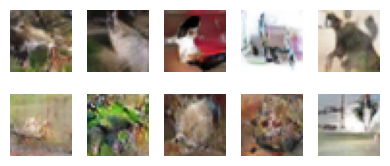

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 236, Discriminator Loss: 0.0005528797628358006, Generator Loss: 0.0008882759721018374


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 237, Discriminator Loss: 0.0005535390228033066, Generator Loss: 0.0008884266135282815


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 238, Discriminator Loss: 0.0005522731225937605, Generator Loss: 0.0008894974598661065


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 239, Discriminator Loss: 0.000554086989723146, Generator Loss: 0.0008886197465471923


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 240, Discriminator Loss: 0.0005550064379349351, Generator Loss: 0.0008879264933057129


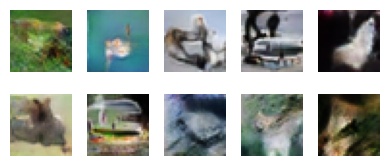

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 241, Discriminator Loss: 0.0005518777179531753, Generator Loss: 0.0008926580776460469


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 242, Discriminator Loss: 0.0005523667787201703, Generator Loss: 0.0008903093985281885


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 243, Discriminator Loss: 0.0005542525323107839, Generator Loss: 0.00088751275325194


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 244, Discriminator Loss: 0.0005516079836525023, Generator Loss: 0.0008902872214093804


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 245, Discriminator Loss: 0.0005525000742636621, Generator Loss: 0.0008886250434443355


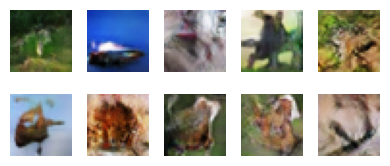

  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 246, Discriminator Loss: 0.0005512444186024368, Generator Loss: 0.0008914608042687178


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 247, Discriminator Loss: 0.0005526444874703884, Generator Loss: 0.0008890391327440739


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 248, Discriminator Loss: 0.0005522597348317504, Generator Loss: 0.0008913392666727304


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 249, Discriminator Loss: 0.0005543246516026556, Generator Loss: 0.000886971945874393


  0%|          | 0/48 [00:00<?, ?it/s]

>Epoch: 250, Discriminator Loss: 0.0005532252253033221, Generator Loss: 0.0008876056526787579


In [27]:
generator_optimizer = Adam(learning_rate=0.0000001, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0000001, beta_1=0.5)

# Other hyperparameters
batch_size = 1024
loss_function = BinaryCrossentropy()

# Training loop
start_epoch = 201
train(start_epoch)

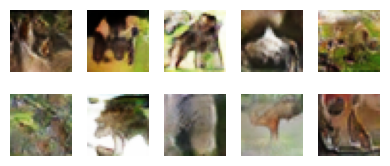

In [31]:
testing(f"{path_to_models}/figure/", start_epoch)

To improve the model there is needed more epochs and also tuning hyperparametrs such learning rate and weight decay of optimizer to avoid "ninja mode in lose function"